In [2]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from model import Neural_Net
from dataset_samplers import RandomCorruptSampler, ClassCorruptSampler, SupervisedSampler 
from corruption_mask_generators import RandomMaskGenerator, CorrelationMaskGenerator
from training import train_contrastive_loss, train_classification
from utils import *

import warnings
warnings.filterwarnings('ignore')
print("Disabled warnings!")

print(f"Using DEVICE: {DEVICE}")

/home/wei/anaconda3/envs/pfgen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Disabled warnings!
Using DEVICE: cuda


In [3]:
METHODS = ['No Pre-train', 'Conventional', 'Class-Conditioned', 'Oracle']
seed = 1234
fix_seed(seed)

Data and Model Preparation

In [4]:
data = datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_targets, test_targets = train_test_split(
    data, target, test_size=0.2, stratify=target, random_state=seed)

assert np.all(np.unique(train_targets).sort() == np.unique(test_targets).sort())
n_classes = len(np.unique(train_targets))

train_data, test_data = preprocess_datasets(train_data, test_data, normalize_numerical_features=True)
one_hot_encoder = fit_one_hot_encoder(preprocessing.OneHotEncoder(handle_unknown='ignore', \
                                                                              drop='if_binary',   \
                                                                              sparse_output=False), \
                                                  train_data)
label_encoder_target = preprocessing.LabelEncoder()
train_targets = label_encoder_target.fit_transform(train_targets)
test_targets = label_encoder_target.transform(test_targets)
print(f"Class distributions:")
unique, counts = np.unique(train_targets, return_counts=True)
print(f"Training: cls: {unique}; counts: {counts}")
unique, counts = np.unique(test_targets, return_counts=True)
print(f"Testing: cls: {unique}; counts: {counts}")

Data preprocess finished! Dropped 0 features: []. Normalized numerical features.
Class distributions:
Training: cls: [0 1]; counts: [170 285]
Testing: cls: [0 1]; counts: [42 72]


In [5]:
# separate out labeled subset
n_train_samples_labeled = int(len(train_data)*FRACTION_LABELED)
idxes_tmp = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros(len(train_data), dtype=bool)
mask_train_labeled[idxes_tmp] = True
supervised_sampler = SupervisedSampler(data=train_data[mask_train_labeled], target=train_targets[mask_train_labeled])

In [6]:
# prepare models
models, contrastive_loss_histories, supervised_loss_histories = {}, {}, {}
for method in METHODS:
    models[method] = Neural_Net(
        input_dim=train_data.shape[1],  # model expect one-hot encoded input
        emb_dim=256,
        output_dim=n_classes   
    ).to(DEVICE)

# Firstly, train the supervised learning model on the labeled subset
# freeze the supervised learning encoder as initialized
models['No Pre-train'].freeze_encoder()  
print("Supervised training for no_pretrain...")
train_losses = train_classification(models['No Pre-train'], supervised_sampler, one_hot_encoder)
supervised_loss_histories['No Pre-train'] = train_losses

Supervised training for no_pretrain...


In [7]:
# prepare data samplers for corruption
contrastive_samplers = {}
# Random Sampling: Ignore class information in original corruption
contrastive_samplers['Conventional'] = RandomCorruptSampler(train_data) 
# Oracle Class Sampling: Use oracle info on training labels
contrastive_samplers['Oracle'] = ClassCorruptSampler(train_data, train_targets) 
# Predicted Class Sampling: Use supervised model to obtain pseudo labels at the beginning
bootstrapped_train_targets = get_bootstrapped_targets( \
    train_data, train_targets, models['No Pre-train'], mask_train_labeled, one_hot_encoder)
contrastive_samplers['Class-Conditioned'] = ClassCorruptSampler(train_data, bootstrapped_train_targets) 

mask_generator = RandomMaskGenerator(train_data.shape[1])

Contrastive Learning

In [8]:
for method in METHODS:
    if method == "No Pre-train":
        continue
    train_losses = train_contrastive_loss(models[method], 
                                          method,
                                          contrastive_samplers[method],
                                          supervised_sampler,
                                          mask_generator,
                                          mask_train_labeled,
                                          one_hot_encoder)
    contrastive_loss_histories[method] = train_losses

Contrastive learning for Conventional....


100%|██████████| 500/500 [01:44<00:00,  4.80it/s]


Contrastive learning for Class-Conditioned....


100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


Contrastive learning for Oracle....


100%|██████████| 500/500 [01:55<00:00,  4.31it/s]


Figure saved!


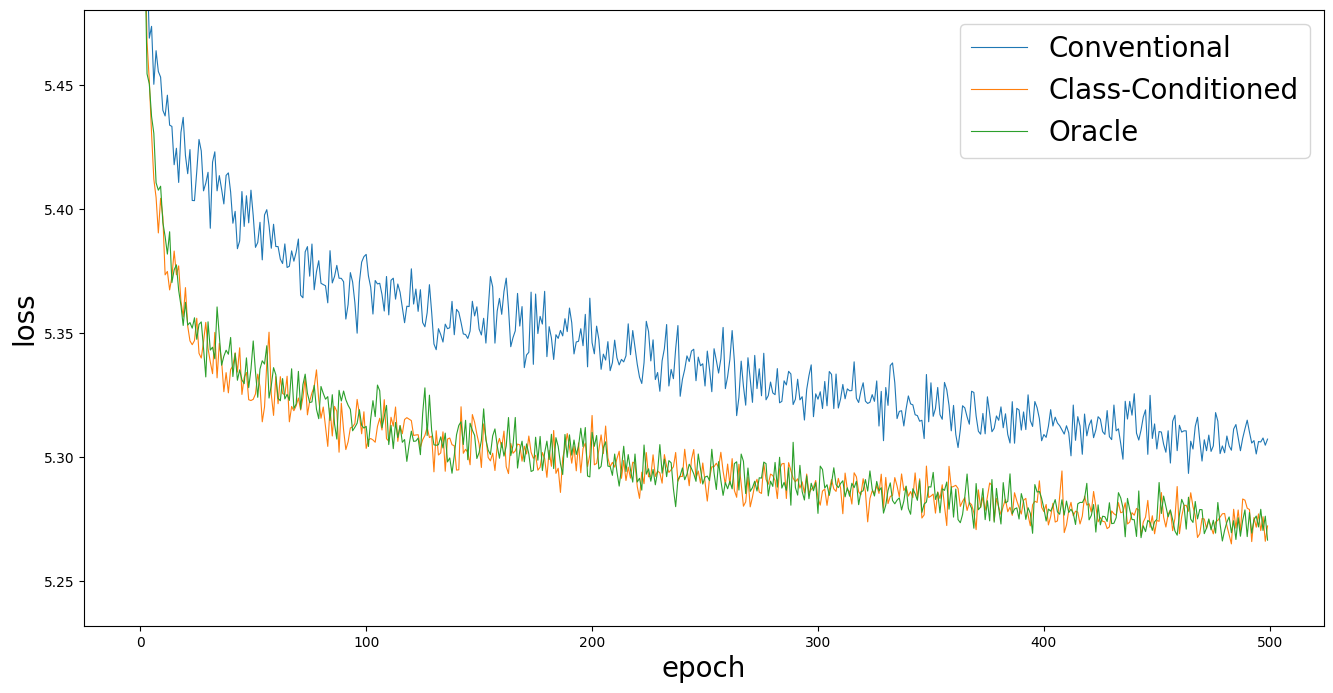

In [9]:
# Plot Training losses
fig, ax = plt.subplots(figsize=(16, 8))
plot_upperbound = 0
for key in METHODS:
    if key == "No Pre-train":
        continue
    ax.plot(contrastive_loss_histories[key], label=key, linewidth=0.8)
    plot_upperbound = max(plot_upperbound, np.max(contrastive_loss_histories[key]))
ax.set_xlabel("epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
ax.set_ylim(top=plot_upperbound*0.925)
ax.legend(fontsize=20)
plt.savefig("learning_curve.pdf", format="pdf", bbox_inches="tight")
print("Figure saved!")
plt.show()


Examine Embeddings

In [10]:
# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in METHODS:
    models[key].eval()
    with torch.no_grad():
        train_embeddings[key] = models[key].get_middle_embedding(
                                    torch.tensor(one_hot_encoder.transform(train_data), dtype=torch.float32).to(DEVICE)).cpu().numpy()
        test_embeddings[key] = models[key].get_middle_embedding(
                                    torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(DEVICE)).cpu().numpy()

Figure saved!


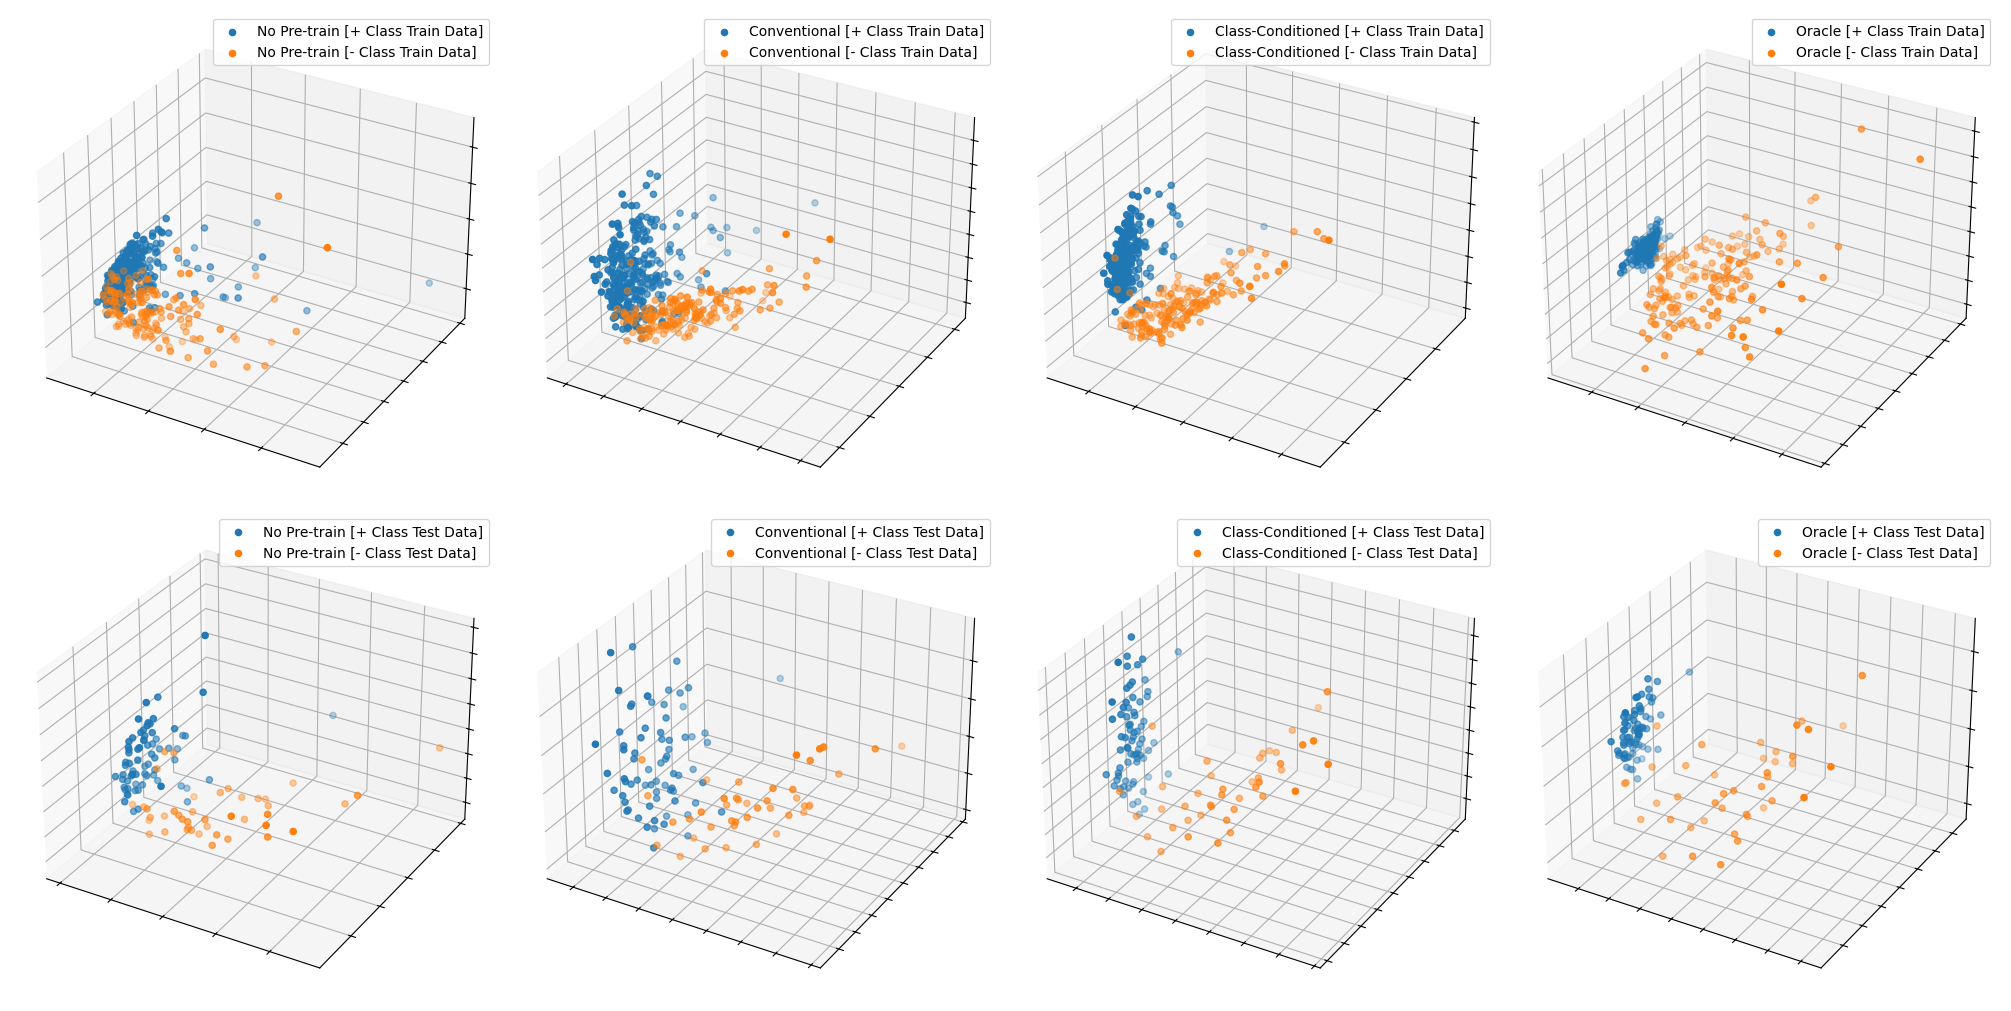

In [18]:
# Visualize using PCA
fig, axes = plt.subplots(figsize=(20, 10), constrained_layout=True)
# Visualzie using PCA (which supports same basis from training to testing)
pca_3D = PCA(n_components=3, copy=True)


for col_id, key in enumerate(['No Pre-train', 'Conventional', 'Class-Conditioned', 'Oracle']):
    reduced_3D = pca_3D.fit_transform(train_embeddings[key])
    positive = train_targets == 1
    ax = fig.add_subplot(2,4,col_id+1, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"{key} [+ Class Train Data]")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"{key} [- Class Train Data]")
    ax.legend()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    reduced_3D = pca_3D.fit_transform(test_embeddings[key])
    positive = test_targets == 1
    ax = fig.add_subplot(2,4,col_id+5, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"{key} [+ Class Test Data]")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"{key} [- Class Test Data]")
    ax.legend()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
axes.set_axis_off()
plt.savefig("embeddings.pdf", format="pdf", bbox_inches="tight")
print("Figure saved!")
plt.show()